In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import unicodedata
import torch.optim as optim
from tqdm import tqdm



In [2]:
import wandb
wandb.login(key="594642013968a68e466138e783dcece6765c43b9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bgorai005 (bgorai005-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
train_path = '/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv'
valid_path = '/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv'
test_path  = '/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv'


 # Attention class

In [4]:

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        nn.init.xavier_uniform_(self.attn.weight)
        self.v.data.normal_(mean=0, std=0.01)

    def forward(self, hidden, encoder_outputs):
        # hidden: [num_layers, batch_size, hidden_size] (decoder's last hidden state)
        # encoder_outputs: [batch_size, src_len, hidden_size]
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        # Use the last layer's hidden state for attention
        hidden = hidden[-1]  # [batch_size, hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch_size, src_len, hidden_size]

        # Compute attention scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch_size, src_len, hidden_size]
        energy = energy.transpose(1, 2)  # [batch_size, hidden_size, src_len]
        v = self.v.repeat(batch_size, 1).unsqueeze(1)  # [batch_size, 1, hidden_size]
        attention_scores = torch.bmm(v, energy).squeeze(1)  # [batch_size, src_len]
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, src_len]

        # Compute context vector
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, hidden_size]
        return  context,attention_weights

# Encoder ,decoder, seq2seq class

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers=1, cell_type='LSTM', dropout=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        self.embedding = nn.Embedding(input_size, embedding_dim)
        rnn_class = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        self.rnn = rnn_class(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        embedded = self.dropout(self.embedding(input_seq))
        batch_size = input_seq.size(0)
        device = input_seq.device
        if self.cell_type == 'LSTM':
            hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                      torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        else:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden


class Decoder(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_size, num_layers=1, cell_type='LSTM', dropout=0.2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.attention = Attention(hidden_size)
        rnn_class = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        self.rnn = rnn_class(
            input_size=embedding_dim + hidden_size,  # Input includes context vector
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.out = nn.Linear(hidden_size * 2, output_size)  # Combine RNN output and context
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input_char, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input_char))  # [batch_size, 1, embedding_dim]
        context, attention_weights = self.attention(hidden[0] if self.cell_type == 'LSTM' else hidden, encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, embedding_dim + hidden_size]
        output, hidden = self.rnn(rnn_input, hidden)
        output = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)  # [batch_size, hidden_size * 2]
        output = self.softmax(self.out(output))
        return output, hidden, attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)
        target_vocab_size = self.decoder.embedding.num_embeddings
        device = source.device
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        encoder_outputs, hidden = self.encoder(source)
        if self.encoder.num_layers != self.decoder.num_layers:
            if self.encoder.cell_type == 'LSTM':
                h_n, c_n = hidden
                if self.decoder.num_layers > self.encoder.num_layers:
                    extra_layers = self.decoder.num_layers - self.encoder.num_layers
                    extra_h = torch.zeros(extra_layers, batch_size, self.decoder.hidden_size).to(device)
                    extra_c = torch.zeros(extra_layers, batch_size, self.decoder.hidden_size).to(device)
                    h_n = torch.cat([h_n, extra_h], dim=0)
                    c_n = torch.cat([c_n, extra_c], dim=0)
                else:
                    h_n = h_n[:self.decoder.num_layers]
                    c_n = c_n[:self.decoder.num_layers]
                hidden = (h_n, c_n)
            else:
                if self.decoder.num_layers > self.encoder.num_layers:
                    extra_layers = self.decoder.num_layers - self.encoder.num_layers
                    extra_h = torch.zeros(extra_layers, batch_size, self.decoder.hidden_size).to(device)
                    hidden = torch.cat([hidden, extra_h], dim=0)
                else:
                    hidden = hidden[:self.decoder.num_layers]
        decoder_input = target[:, 0].unsqueeze(1)
        for t in range(1, target_len):
            output, hidden, _ = self.decoder(decoder_input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            decoder_input = target[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)
        return outputs

    def predict(self, src, max_len=30, beam_size=3):
        self.eval()
        batch_size = src.size(0)
        device = src.device
        encoder_outputs, hidden = self.encoder(src)
        outputs = []
        for i in range(batch_size):
            if self.encoder.cell_type == 'LSTM':
                h = hidden[0][:, i:i+1].contiguous()
                c = hidden[1][:, i:i+1].contiguous()
                hidden_state = (h, c)
            else:
                hidden_state = hidden[:, i:i+1].contiguous()
            if self.encoder.num_layers != self.decoder.num_layers:
                if self.encoder.cell_type == 'LSTM':
                    h_n, c_n = hidden_state
                    if self.decoder.num_layers > self.encoder.num_layers:
                        extra_layers = self.decoder.num_layers - self.encoder.num_layers
                        extra_h = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        extra_c = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        h_n = torch.cat([h_n, extra_h], dim=0)
                        c_n = torch.cat([c_n, extra_c], dim=0)
                    else:
                        h_n = h_n[:self.decoder.num_layers]
                        c_n = c_n[:self.decoder.num_layers]
                    hidden_state = (h_n, c_n)
                else:
                    if self.decoder.num_layers > self.encoder.num_layers:
                        extra_layers = self.decoder.num_layers - self.encoder.num_layers
                        extra_h = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        hidden_state = torch.cat([hidden_state, extra_h], dim=0)
                    else:
                        hidden_state = hidden_state[:self.decoder.num_layers]
            beams = [(torch.tensor([1], device=device), 0.0, hidden_state, [])]  # [sequence, score, hidden, attention_weights]
            for _ in range(max_len):
                new_beams = []
                for seq, score, h, attn_weights in beams:
                    input_char = seq[-1].unsqueeze(0).unsqueeze(0)
                    output, h_new, attn_w = self.decoder(input_char, h, encoder_outputs[i:i+1])  # Fix: Use [i:i+1] instead of [:, i:i+1]
                    probs = torch.log_softmax(output, dim=-1).squeeze(0)
                    topk = torch.topk(probs, beam_size)
                    for idx, prob in zip(topk.indices, topk.values):
                        new_seq = torch.cat([seq, idx.unsqueeze(0)])
                        new_score = score + prob.item()
                        new_attn_weights = attn_weights + [attn_w]
                        if self.decoder.cell_type == 'LSTM':
                            h_new = (h_new[0].contiguous(), h_new[1].contiguous())
                        else:
                            h_new = h_new.contiguous()
                        new_beams.append((new_seq, new_score, h_new, new_attn_weights))
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
                if beams[0][0][-1].item() == 2:  # Stop if <EOS>
                    break
            outputs.append(beams[0][0][1:])  # Exclude <SOS>
        return outputs

    def predict_with_attention(self, src, max_len=30, beam_size=3):
        self.eval()
        batch_size = src.size(0)
        device = src.device
        encoder_outputs, hidden = self.encoder(src)
        outputs = []
        all_attn_weights = []
        for i in range(batch_size):
            if self.encoder.cell_type == 'LSTM':
                h = hidden[0][:, i:i+1].contiguous()
                c = hidden[1][:, i:i+1].contiguous()
                hidden_state = (h, c)
            else:
                hidden_state = hidden[:, i:i+1].contiguous()
            if self.encoder.num_layers != self.decoder.num_layers:
                if self.encoder.cell_type == 'LSTM':
                    h_n, c_n = hidden_state
                    if self.decoder.num_layers > self.encoder.num_layers:
                        extra_layers = self.decoder.num_layers - self.encoder.num_layers
                        extra_h = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        extra_c = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        h_n = torch.cat([h_n, extra_h], dim=0)
                        c_n = torch.cat([c_n, extra_c], dim=0)
                    else:
                        h_n = h_n[:self.decoder.num_layers]
                        c_n = c_n[:self.decoder.num_layers]
                    hidden_state = (h_n, c_n)
                else:
                    if self.decoder.num_layers > self.encoder.num_layers:
                        extra_layers = self.decoder.num_layers - self.encoder.num_layers
                        extra_h = torch.zeros(extra_layers, 1, self.decoder.hidden_size).to(device)
                        hidden_state = torch.cat([hidden_state, extra_h], dim=0)
                    else:
                        hidden_state = hidden_state[:self.decoder.num_layers]
            beams = [(torch.tensor([1], device=device), 0.0, hidden_state, [])]  # [sequence, score, hidden, attention_weights]
            for _ in range(max_len):
                new_beams = []
                for seq, score, h, attn_weights in beams:
                    input_char = seq[-1].unsqueeze(0).unsqueeze(0)
                    output, h_new, attn_w = self.decoder(input_char, h, encoder_outputs[i:i+1])
                    probs = torch.log_softmax(output, dim=-1).squeeze(0)
                    topk = torch.topk(probs, beam_size)
                    for idx, prob in zip(topk.indices, topk.values):
                        new_seq = torch.cat([seq, idx.unsqueeze(0)])
                        new_score = score + prob.item()
                        new_attn_weights = attn_weights + [attn_w]
                        if self.decoder.cell_type == 'LSTM':
                            h_new = (h_new[0].contiguous(), h_new[1].contiguous())
                        else:
                            h_new = h_new.contiguous()
                        new_beams.append((new_seq, new_score, h_new, new_attn_weights))
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
                if beams[0][0][-1].item() == 2:  # Stop if <EOS>
                    break
            outputs.append(beams[0][0][1:])  # Exclude <SOS>
            all_attn_weights.append(beams[0][3])  # Store attention weights
        return outputs, all_attn_weights






In [6]:

class Trainer:
    def __init__(self, model, train_loader, val_loader, config, device='cpu', save_path='best_model.pt'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config
        self.teacher_forcing_ratio = config.teacher_forcing
        self.num_epochs = config.epochs
        self.save_path = save_path
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)  # Changed to CrossEntropyLoss
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)
        self.src_vocab = None  # To store vocab for predictions
        self.tgt_vocab = None

    def compute_token_accuracy(self, outputs, targets):
        """Compute token-level accuracy."""
        outputs = outputs.argmax(dim=-1)  # [batch_size, seq_len]
        non_pad_mask = (targets != 0) & (targets != 1) & (targets != 2)  # Exclude <PAD>, <SOS>, <EOS>
        correct = (outputs == targets) & non_pad_mask
        total = non_pad_mask.sum().item()
        correct = correct.sum().item()
        return correct / total if total > 0 else 0.0

    def compute_sequence_accuracy(self, outputs, targets):
        """Compute sequence-level accuracy."""
        outputs = outputs.argmax(dim=-1)  # [batch_size, seq_len]
        correct = 0
        total = outputs.size(0)
        for pred, tgt in zip(outputs, targets):
            # Compare sequences, ignoring <PAD>, <SOS>, <EOS>
            pred = pred[(tgt != 0) & (tgt != 1) & (tgt != 2)]
            tgt = tgt[(tgt != 0) & (tgt != 1) & (tgt != 2)]
            if torch.equal(pred, tgt):
                correct += 1
        return correct / total if total > 0 else 0.0

    def train_epoch(self):
        self.model.train()
        total_loss, total_token_acc, total_seq_acc, total_samples = 0.0, 0.0, 0.0, 0

        pbar = tqdm(self.train_loader, desc="Training", leave=False)
        for src, tgt, _, _ in pbar:  # Adjusted for src_strs, tgt_strs from DataLoader
            src, tgt = src.to(self.device), tgt.to(self.device)
            self.optimizer.zero_grad()

            output = self.model(src, tgt, self.teacher_forcing_ratio)
            output = output[:, 1:].contiguous().view(-1, output.size(-1))
            tgt_flat = tgt[:, 1:].contiguous().view(-1)

            loss = self.criterion(output, tgt_flat)
            loss.backward()
            self.optimizer.step()

            batch_size = src.size(0)
            token_acc = self.compute_token_accuracy(
                output.view(batch_size, -1, output.size(-1)), tgt[:, 1:]
            )
            seq_acc = self.compute_sequence_accuracy(
                output.view(batch_size, -1, output.size(-1)), tgt[:, 1:]
            )

            total_loss += loss.item() * batch_size
            total_token_acc += token_acc * batch_size
            total_seq_acc += seq_acc * batch_size
            total_samples += batch_size

            pbar.set_postfix(loss=loss.item(), token_acc=token_acc, seq_acc=seq_acc)

        avg_loss = total_loss / total_samples
        avg_token_acc = total_token_acc / total_samples
        avg_seq_acc = total_seq_acc / total_samples
        return avg_loss, avg_token_acc, avg_seq_acc

    def evaluate(self, loader):
        self.model.eval()
        total_loss, total_token_acc, total_seq_acc, total_samples = 0.0, 0.0, 0.0, 0

        pbar = tqdm(loader, desc="Evaluating", leave=False)
        with torch.no_grad():
            for src, tgt, _, _ in pbar:
                src, tgt = src.to(self.device), tgt.to(self.device)

                output = self.model(src, tgt, teacher_forcing_ratio=0.0)
                output = output[:, 1:].contiguous().view(-1, output.size(-1))
                tgt_flat = tgt[:, 1:].contiguous().view(-1)

                loss = self.criterion(output, tgt_flat)

                batch_size = src.size(0)
                token_acc = self.compute_token_accuracy(
                    output.view(batch_size, -1, output.size(-1)), tgt[:, 1:]
                )
                seq_acc = self.compute_sequence_accuracy(
                    output.view(batch_size, -1, output.size(-1)), tgt[:, 1:]
                )

                total_loss += loss.item() * batch_size
                total_token_acc += token_acc * batch_size
                total_seq_acc += seq_acc * batch_size
                total_samples += batch_size

                pbar.set_postfix(loss=loss.item(), token_acc=token_acc, seq_acc=seq_acc)

        avg_loss = total_loss / total_samples
        avg_token_acc = total_token_acc / total_samples
        avg_seq_acc = total_seq_acc / total_samples
        return avg_loss, avg_token_acc, avg_seq_acc

    def train(self, src_vocab, tgt_vocab):
        """Train the model, logging metrics and predictions to Wandb."""
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        best_val_seq_acc = 0.0
        patience = getattr(self.config, 'patience', 3)
        patience_counter = 0

        for epoch in range(1, self.num_epochs + 1):
            # Train
            train_loss, train_token_acc, train_seq_acc = self.train_epoch()
            # Evaluate
            val_loss, val_token_acc, val_seq_acc = self.evaluate(self.val_loader)

            # Print metrics
            print(f'\nEpoch {epoch}/{self.num_epochs}')
            print(f'Train Loss: {train_loss:.4f} | Train Token Acc: {train_token_acc*100:.2f}% | Train Seq Acc: {train_seq_acc*100:.2f}%')
            print(f'Val Loss:   {val_loss:.4f} | Val Token Acc:   {val_token_acc*100:.2f}% | Val Seq Acc:   {val_seq_acc*100:.2f}%')
            print('-' * 60)

            # Log metrics to Wandb
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                 'val_loss': val_loss,

                'train_token_accuracy': train_token_acc,
                'val_token_accuracy': val_token_acc,
                'train_sequence_accuracy': train_seq_acc,
                               
                'val_sequence_accuracy': val_seq_acc
            })

            # Log sample predictions
            src_sample, tgt_sample, src_strs, tgt_strs = next(iter(self.val_loader))
            src_sample = src_sample.to(self.device)
            preds = self.model.predict(src_sample[:5], max_len=30, beam_size=self.config.beam_size)

            inv_src_vocab = {v: k for k, v in src_vocab.items()}
            inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}
            table = wandb.Table(columns=["Input", "Target", "Prediction"])
            for i in range(len(preds)):
                input_str = ''.join([inv_src_vocab.get(id.item(), '?') for id in src_sample[i] if id.item() not in [0, src_vocab['<EOS>']]])
                target_str = ''.join([inv_tgt_vocab.get(id.item(), '?') for id in tgt_sample[i] if id.item() not in [0, tgt_vocab['<EOS>'], tgt_vocab['<SOS>']]])
                pred_str = ''.join([inv_tgt_vocab.get(id.item(), '?') for id in preds[i] if id.item() not in [0, tgt_vocab['<EOS>']]])
                table.add_data(input_str, target_str, pred_str)
            wandb.log({"predictions": table})

            # Early stopping and checkpoint
            if val_seq_acc > best_val_seq_acc:
                best_val_seq_acc = val_seq_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), self.save_path)
                print(f"✅ New best model saved with val sequence accuracy: {val_seq_acc*100:.2f}%")
            else:
                patience_counter += 1
                print(f"⚠️ No improvement. Patience counter: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("🛑 Early stopping triggered.")
                    break


# class depreproc

In [7]:
class DataPreprocessor:
    def __init__(self, batch_size=32, device='cpu'):
        self.batch_size = batch_size
        self.device = device
        self.src_vocab = None
        self.tgt_vocab = None
        self.PAD_TOKEN = '<PAD>'
        self.SOS_TOKEN = '<SOS>'
        self.EOS_TOKEN = '<EOS>'
        self.UNK_TOKEN = '<UNK>'
        self.PAD_IDX = 0
        self.SOS_IDX = 1
        self.EOS_IDX = 2
        self.UNK_IDX = 3

    def normalize_string(self, s):
        s = unicodedata.normalize('NFC', str(s))
        if all(ord(c) < 128 for c in s):
            s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
            s = s.lower()
        return s.strip()

    def load_dataset(self, file_path=None, data_frame=None):
        if file_path:
            try:
                data = pd.read_csv(file_path, sep='\t', header=None)
            except:
                data = pd.read_csv(file_path, header=None)
        elif data_frame is not None:
            data = data_frame.copy()
        else:
            raise ValueError("Either file_path or data_frame must be provided.")
        data = data.rename(columns={0: 'tgt', 1: 'src'})
        data['src'] = data['src'].apply(self.normalize_string)
        data['tgt'] = data['tgt'].apply(self.normalize_string)
        return data

    def create_vocab(self, data, column):
        vocab = {self.PAD_TOKEN: self.PAD_IDX, self.SOS_TOKEN: self.SOS_IDX,
                 self.EOS_TOKEN: self.EOS_IDX, self.UNK_TOKEN: self.UNK_IDX}
        for seq in data[column]:
            if pd.notna(seq):
                for char in seq:
                    if char not in vocab:
                        vocab[char] = len(vocab)
        return vocab

    def build_vocabularies(self, train_data):
        self.src_vocab = self.create_vocab(train_data, 'src')
        self.tgt_vocab = self.create_vocab(train_data, 'tgt')
        return self.src_vocab, self.tgt_vocab

    class TranslationDataset(Dataset):
        def __init__(self, data, input_vocab, output_vocab):
            self.data = data
            self.input_vocab = input_vocab
            self.output_vocab = output_vocab

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            src = [self.input_vocab.get(c, self.input_vocab['<UNK>']) for c in self.data.iloc[idx, 1]] + [self.input_vocab['<EOS>']]
            tgt = [self.output_vocab['<SOS>']] + [self.output_vocab.get(c, self.output_vocab['<UNK>']) for c in self.data.iloc[idx, 0]] + [self.output_vocab['<EOS>']]
            src_str = self.data.iloc[idx, 1]
            tgt_str = self.data.iloc[idx, 0]
            return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long), src_str, tgt_str

    def pad_collate(self, batch):
        src_batch, tgt_batch, src_strs, tgt_strs = zip(*batch)
        src_padded = pad_sequence(src_batch, batch_first=True, padding_value=self.PAD_IDX)
        tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=self.PAD_IDX)
        return src_padded, tgt_padded, list(src_strs), list(tgt_strs)

    def prepare_data(self, train_data, val_data, test_data):
        if self.src_vocab is None or self.tgt_vocab is None:
            self.build_vocabularies(train_data)
        train_dataset = self.TranslationDataset(train_data, self.src_vocab, self.tgt_vocab)
        val_dataset = self.TranslationDataset(val_data, self.src_vocab, self.tgt_vocab)
        test_dataset = self.TranslationDataset(test_data, self.src_vocab, self.tgt_vocab)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True,
                                 collate_fn=self.pad_collate, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False,
                                collate_fn=self.pad_collate, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False,
                                 collate_fn=self.pad_collate, pin_memory=True)
        return train_loader, val_loader, test_loader
import torch

In [12]:
def train_loader(
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    valid_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv',
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='/kaggle/working/best_model.pt'
):
    """
    Training function for running a WandB sweep on the Bengali Dakshina dataset with attention-based Seq2Seq.
    """
    # Initialize WandB
    wandb.init(project="assignment_3")
    config = wandb.config

    # Construct a descriptive run name
    run_name = (
        f"attn-cell-{config.cell_type}"
        f"-embed-{config.emb_dim}"
        f"-enc_layers-{config.enc_layers}"
        f"-dec_layers-{config.dec_layers}"
        f"-hid-{config.hidden_dim}"
        f"-dropout-{config.dropout}"
        f"-bs-{config.batch_size}"
        f"-lr-{config.learning_rate}"
        f"-tf-{config.teacher_forcing}"
        f"-beam-{config.beam_size}"
    )
    wandb.run.name = run_name

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(batch_size=config.batch_size, device=device)

    # Load datasets
    train_data = preprocessor.load_dataset(train_path)
    val_data = preprocessor.load_dataset(valid_path)
    test_data = preprocessor.load_dataset(test_path)

    # Prepare data loaders
    train_loader, val_loader, test_loader = preprocessor.prepare_data(train_data, val_data, test_data)

    # Initialize model
    encoder = Encoder(
        input_size=len(preprocessor.src_vocab),
        embedding_dim=config.emb_dim,
        hidden_size=config.hidden_dim,
        num_layers=config.enc_layers,
        cell_type=config.cell_type,
        dropout=config.dropout
    )
    decoder = Decoder(
        output_size=len(preprocessor.tgt_vocab),
        embedding_dim=config.emb_dim,
        hidden_size=config.hidden_dim,
        num_layers=config.dec_layers,
        cell_type=config.cell_type,
        dropout=config.dropout
    )
    model = Seq2Seq(encoder, decoder).to(device)

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        device=device,
        save_path=save_path
    )

    # Train with vocabularies
    trainer.train(preprocessor.src_vocab, preprocessor.tgt_vocab)

   

    #Finish Wandb run
    wandb.finish()



In [ ]:
# Wandb sweep config
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_sequence_accuracy', 'goal': 'maximize'},
    'parameters': {
        'emb_dim': {'values': [64, 128, 256]},
        'hidden_dim': {'values': [128, 256]},
        'enc_layers': {'values': [1, 2, 3]},
        'dec_layers': {'values': [1, 2, 3]},
        'cell_type': {'values': ['LSTM', 'GRU', 'RNN']},
        'dropout': {'values': [0.2, 0.3, 0.4]},
        'batch_size': {'values': [32, 64, 128]},
        'learning_rate': {'values': [0.001, 0.0005, 0.0001]},
        'teacher_forcing': {'values': [0.5, 0.7, 0.9]},
        'beam_size': {'values': [1, 3, 5]},
        'patience': {'value': 3},
        'epochs': {'values': [10,15]}
    }
}


In [ ]:
if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project="assignment_3")
    wandb.agent(sweep_id, function=train_loader, count=10)

Create sweep with ID: dkvqk4vu
Sweep URL: https://wandb.ai/bgorai005-iit-madras/assignment_3/sweeps/dkvqk4vu


wandb: Agent Starting Run: orntkof9 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 128
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005
wandb: 	patience: 3
wandb: 	teacher_forcing: 0.9



Epoch 1/10
Train Loss: 1.0375 | Train Token Acc: 66.74% | Train Seq Acc: 15.08%
Val Loss:   1.7244 | Val Token Acc:   60.98% | Val Seq Acc:   23.17%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 23.17%



Epoch 2/10
Train Loss: 0.5350 | Train Token Acc: 81.48% | Train Seq Acc: 28.40%
Val Loss:   1.6374 | Val Token Acc:   63.96% | Val Seq Acc:   26.93%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 26.93%



Epoch 3/10
Train Loss: 0.4461 | Train Token Acc: 84.41% | Train Seq Acc: 34.50%
Val Loss:   1.6635 | Val Token Acc:   65.58% | Val Seq Acc:   30.49%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 30.49%



Epoch 4/10
Train Loss: 0.3994 | Train Token Acc: 86.10% | Train Seq Acc: 38.89%
Val Loss:   1.5935 | Val Token Acc:   67.63% | Val Seq Acc:   32.64%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 32.64%



Epoch 5/10
Train Loss: 0.3624 | Train Token Acc: 87.32% | Train Seq Acc: 42.29%
Val Loss:   1.5222 | Val Token Acc:   69.30% | Val Seq Acc:   33.85%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 33.85%



Epoch 6/10
Train Loss: 0.3386 | Train Token Acc: 88.22% | Train Seq Acc: 45.18%
Val Loss:   1.5207 | Val Token Acc:   69.75% | Val Seq Acc:   35.77%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 35.77%



Epoch 7/10
Train Loss: 0.3154 | Train Token Acc: 88.99% | Train Seq Acc: 47.37%
Val Loss:   1.6004 | Val Token Acc:   68.94% | Val Seq Acc:   34.95%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3



Epoch 8/10
Train Loss: 0.3026 | Train Token Acc: 89.46% | Train Seq Acc: 49.31%
Val Loss:   1.5811 | Val Token Acc:   69.41% | Val Seq Acc:   35.17%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 2/3



Epoch 9/10
Train Loss: 0.2860 | Train Token Acc: 90.05% | Train Seq Acc: 51.11%
Val Loss:   1.6074 | Val Token Acc:   69.35% | Val Seq Acc:   35.47%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 3/3
🛑 Early stopping triggered.


epoch,▁▂▃▄▅▅▆▇█
train_loss,█▃▂▂▂▁▁▁▁
train_sequence_accuracy,▁▄▅▆▆▇▇██
train_token_accuracy,▁▅▆▇▇▇███
val_loss,█▅▆▄▁▁▄▃▄
val_sequence_accuracy,▁▃▅▆▇████
val_token_accuracy,▁▃▅▆██▇██
epoch,9
train_loss,0.28601
train_sequence_accuracy,0.51105
train_token_accuracy,0.90051


wandb: Agent Starting Run: bcc4kywu with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005
wandb: 	patience: 3
wandb: 	teacher_forcing: 0.5



Epoch 1/15
Train Loss: 1.6997 | Train Token Acc: 47.34% | Train Seq Acc: 6.47%
Val Loss:   1.3787 | Val Token Acc:   57.35% | Val Seq Acc:   15.65%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 15.65%



Epoch 2/15
Train Loss: 0.9787 | Train Token Acc: 68.13% | Train Seq Acc: 17.75%
Val Loss:   1.2653 | Val Token Acc:   62.34% | Val Seq Acc:   22.49%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 22.49%



Epoch 3/15
Train Loss: 0.8014 | Train Token Acc: 73.68% | Train Seq Acc: 23.78%
Val Loss:   1.2227 | Val Token Acc:   64.60% | Val Seq Acc:   25.49%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 25.49%



Epoch 4/15
Train Loss: 0.7101 | Train Token Acc: 76.63% | Train Seq Acc: 28.00%
Val Loss:   1.1773 | Val Token Acc:   65.42% | Val Seq Acc:   27.20%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 27.20%



Epoch 5/15
Train Loss: 0.6505 | Train Token Acc: 78.61% | Train Seq Acc: 31.51%
Val Loss:   1.1494 | Val Token Acc:   67.41% | Val Seq Acc:   29.39%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 29.39%



Epoch 6/15
Train Loss: 0.5954 | Train Token Acc: 80.37% | Train Seq Acc: 34.77%
Val Loss:   1.1466 | Val Token Acc:   68.79% | Val Seq Acc:   31.24%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 31.24%



Epoch 7/15
Train Loss: 0.5575 | Train Token Acc: 81.63% | Train Seq Acc: 37.34%
Val Loss:   1.1090 | Val Token Acc:   68.54% | Val Seq Acc:   31.11%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3



Epoch 8/15
Train Loss: 0.5276 | Train Token Acc: 82.67% | Train Seq Acc: 39.56%
Val Loss:   1.0846 | Val Token Acc:   70.72% | Val Seq Acc:   32.27%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 32.27%



Epoch 9/15
Train Loss: 0.4993 | Train Token Acc: 83.59% | Train Seq Acc: 41.64%
Val Loss:   1.0755 | Val Token Acc:   70.19% | Val Seq Acc:   33.14%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 33.14%



Epoch 10/15
Train Loss: 0.4796 | Train Token Acc: 84.26% | Train Seq Acc: 43.25%
Val Loss:   1.1234 | Val Token Acc:   69.91% | Val Seq Acc:   33.46%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 33.46%



Epoch 11/15
Train Loss: 0.4596 | Train Token Acc: 84.90% | Train Seq Acc: 45.00%
Val Loss:   1.1164 | Val Token Acc:   69.93% | Val Seq Acc:   33.18%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3



Epoch 12/15
Train Loss: 0.4364 | Train Token Acc: 85.59% | Train Seq Acc: 46.50%
Val Loss:   1.1311 | Val Token Acc:   70.35% | Val Seq Acc:   34.67%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 34.67%



Epoch 13/15
Train Loss: 0.4194 | Train Token Acc: 86.22% | Train Seq Acc: 47.99%
Val Loss:   1.1715 | Val Token Acc:   69.46% | Val Seq Acc:   33.99%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3



Epoch 14/15
Train Loss: 0.4056 | Train Token Acc: 86.71% | Train Seq Acc: 49.47%
Val Loss:   1.0913 | Val Token Acc:   71.00% | Val Seq Acc:   33.62%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 2/3



Epoch 15/15
Train Loss: 0.3943 | Train Token Acc: 87.03% | Train Seq Acc: 50.41%
Val Loss:   1.1119 | Val Token Acc:   71.06% | Val Seq Acc:   34.26%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 3/3
🛑 Early stopping triggered.


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train_sequence_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇███
train_token_accuracy,▁▅▆▆▇▇▇▇▇██████
val_loss,█▅▄▃▃▃▂▁▁▂▂▂▃▁▂
val_sequence_accuracy,▁▄▅▅▆▇▇▇▇█▇████
val_token_accuracy,▁▄▅▅▆▇▇██▇▇█▇██
epoch,15
train_loss,0.39429
train_sequence_accuracy,0.50412
train_token_accuracy,0.87033


wandb: Agent Starting Run: wwcr9tn9 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.4
wandb: 	emb_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005
wandb: 	patience: 3
wandb: 	teacher_forcing: 0.5



Epoch 1/10
Train Loss: 1.2553 | Train Token Acc: 60.18% | Train Seq Acc: 13.11%
Val Loss:   1.3224 | Val Token Acc:   61.12% | Val Seq Acc:   18.62%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 18.62%



Epoch 2/10
Train Loss: 0.8439 | Train Token Acc: 72.28% | Train Seq Acc: 22.62%
Val Loss:   1.2616 | Val Token Acc:   62.77% | Val Seq Acc:   23.22%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 23.22%



Epoch 3/10
Train Loss: 0.7371 | Train Token Acc: 75.64% | Train Seq Acc: 27.04%
Val Loss:   1.2123 | Val Token Acc:   64.62% | Val Seq Acc:   25.82%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 25.82%



Epoch 4/10
Train Loss: 0.6840 | Train Token Acc: 77.40% | Train Seq Acc: 29.92%
Val Loss:   1.1474 | Val Token Acc:   67.09% | Val Seq Acc:   27.49%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 27.49%



Epoch 5/10
Train Loss: 0.6404 | Train Token Acc: 78.84% | Train Seq Acc: 32.35%
Val Loss:   1.1521 | Val Token Acc:   67.41% | Val Seq Acc:   29.23%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 29.23%



Epoch 6/10
Train Loss: 0.6175 | Train Token Acc: 79.65% | Train Seq Acc: 34.18%
Val Loss:   1.1879 | Val Token Acc:   66.49% | Val Seq Acc:   28.97%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3



Epoch 7/10
Train Loss: 0.5928 | Train Token Acc: 80.43% | Train Seq Acc: 35.54%
Val Loss:   1.1304 | Val Token Acc:   68.16% | Val Seq Acc:   30.71%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 30.71%



Epoch 8/10
Train Loss: 0.5777 | Train Token Acc: 80.98% | Train Seq Acc: 36.65%
Val Loss:   1.1178 | Val Token Acc:   68.86% | Val Seq Acc:   31.13%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 31.13%



Epoch 9/10
Train Loss: 0.5589 | Train Token Acc: 81.59% | Train Seq Acc: 37.98%
Val Loss:   1.1325 | Val Token Acc:   68.74% | Val Seq Acc:   31.44%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 31.44%



Epoch 10/10
Train Loss: 0.5481 | Train Token Acc: 82.01% | Train Seq Acc: 38.96%
Val Loss:   1.1302 | Val Token Acc:   69.08% | Val Seq Acc:   31.35%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
train_sequence_accuracy,▁▄▅▆▆▇▇▇██
train_token_accuracy,▁▅▆▇▇▇▇███
val_loss,█▆▄▂▂▃▁▁▂▁
val_sequence_accuracy,▁▄▅▆▇▇████
val_token_accuracy,▁▂▄▆▇▆▇███
epoch,10
train_loss,0.54805
train_sequence_accuracy,0.38963
train_token_accuracy,0.8201


wandb: Agent Starting Run: 66q9f7mm with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.0005
wandb: 	patience: 3
wandb: 	teacher_forcing: 0.5



Epoch 1/10
Train Loss: 2.4040 | Train Token Acc: 26.98% | Train Seq Acc: 0.91%
Val Loss:   1.7093 | Val Token Acc:   45.38% | Val Seq Acc:   5.36%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 5.36%



Epoch 2/10
Train Loss: 1.3070 | Train Token Acc: 57.84% | Train Seq Acc: 9.32%
Val Loss:   1.3184 | Val Token Acc:   58.62% | Val Seq Acc:   16.36%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 16.36%



Epoch 3/10
Train Loss: 1.0280 | Train Token Acc: 66.47% | Train Seq Acc: 15.92%
Val Loss:   1.2539 | Val Token Acc:   61.82% | Val Seq Acc:   20.84%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 20.84%



Epoch 4/10
Train Loss: 0.9003 | Train Token Acc: 70.56% | Train Seq Acc: 20.42%
Val Loss:   1.2203 | Val Token Acc:   63.87% | Val Seq Acc:   24.11%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 24.11%



Epoch 5/10
Train Loss: 0.8061 | Train Token Acc: 73.53% | Train Seq Acc: 23.88%
Val Loss:   1.1971 | Val Token Acc:   65.12% | Val Seq Acc:   26.23%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 26.23%



Epoch 6/10
Train Loss: 0.7492 | Train Token Acc: 75.41% | Train Seq Acc: 26.69%
Val Loss:   1.1588 | Val Token Acc:   65.94% | Val Seq Acc:   27.87%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 27.87%



Epoch 7/10
Train Loss: 0.6972 | Train Token Acc: 77.07% | Train Seq Acc: 29.33%
Val Loss:   1.1690 | Val Token Acc:   65.87% | Val Seq Acc:   28.72%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 28.72%



Epoch 8/10
Train Loss: 0.6594 | Train Token Acc: 78.40% | Train Seq Acc: 31.73%
Val Loss:   1.1106 | Val Token Acc:   67.06% | Val Seq Acc:   30.15%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 30.15%



Epoch 9/10
Train Loss: 0.6190 | Train Token Acc: 79.65% | Train Seq Acc: 33.68%
Val Loss:   1.1725 | Val Token Acc:   67.55% | Val Seq Acc:   31.50%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 31.50%



Epoch 10/10
Train Loss: 0.5968 | Train Token Acc: 80.45% | Train Seq Acc: 35.64%
Val Loss:   1.1504 | Val Token Acc:   67.85% | Val Seq Acc:   31.85%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 31.85%


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
train_sequence_accuracy,▁▃▄▅▆▆▇▇██
train_token_accuracy,▁▅▆▇▇▇████
val_loss,█▃▃▂▂▂▂▁▂▁
val_sequence_accuracy,▁▄▅▆▇▇▇███
val_token_accuracy,▁▅▆▇▇▇▇███
epoch,10
train_loss,0.59678
train_sequence_accuracy,0.35639
train_token_accuracy,0.80453


wandb: Agent Starting Run: 5qpfxqvz with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.0005
wandb: 	patience: 3
wandb: 	teacher_forcing: 0.9



Epoch 1/15
Train Loss: 1.4217 | Train Token Acc: 55.95% | Train Seq Acc: 8.66%
Val Loss:   1.7586 | Val Token Acc:   58.19% | Val Seq Acc:   18.17%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 18.17%



Epoch 2/15
Train Loss: 0.6648 | Train Token Acc: 77.45% | Train Seq Acc: 22.24%
Val Loss:   1.7329 | Val Token Acc:   61.52% | Val Seq Acc:   24.31%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 24.31%



Epoch 3/15
Train Loss: 0.5321 | Train Token Acc: 81.71% | Train Seq Acc: 29.04%
Val Loss:   1.7618 | Val Token Acc:   63.46% | Val Seq Acc:   25.84%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 25.84%



Epoch 4/15
Train Loss: 0.4668 | Train Token Acc: 83.85% | Train Seq Acc: 33.25%
Val Loss:   1.6253 | Val Token Acc:   66.12% | Val Seq Acc:   30.46%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 30.46%



Epoch 5/15
Train Loss: 0.4204 | Train Token Acc: 85.41% | Train Seq Acc: 36.96%
Val Loss:   1.6694 | Val Token Acc:   66.71% | Val Seq Acc:   31.37%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 31.37%



Epoch 6/15
Train Loss: 0.3910 | Train Token Acc: 86.43% | Train Seq Acc: 39.84%
Val Loss:   1.6600 | Val Token Acc:   66.97% | Val Seq Acc:   32.38%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 32.38%



Epoch 7/15
Train Loss: 0.3678 | Train Token Acc: 87.29% | Train Seq Acc: 42.44%
Val Loss:   1.6405 | Val Token Acc:   67.66% | Val Seq Acc:   33.42%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 33.42%



Epoch 8/15
Train Loss: 0.3473 | Train Token Acc: 87.98% | Train Seq Acc: 44.28%
Val Loss:   1.6510 | Val Token Acc:   67.90% | Val Seq Acc:   34.24%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 34.24%



Epoch 9/15
Train Loss: 0.3282 | Train Token Acc: 88.59% | Train Seq Acc: 46.32%
Val Loss:   1.6290 | Val Token Acc:   68.49% | Val Seq Acc:   34.97%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 34.97%



Epoch 10/15
Train Loss: 0.3142 | Train Token Acc: 89.09% | Train Seq Acc: 48.01%
Val Loss:   1.6312 | Val Token Acc:   68.89% | Val Seq Acc:   35.73%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 35.73%



Epoch 11/15
Train Loss: 0.2997 | Train Token Acc: 89.61% | Train Seq Acc: 49.75%
Val Loss:   1.6629 | Val Token Acc:   69.02% | Val Seq Acc:   35.94%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 35.94%



Epoch 12/15
Train Loss: 0.2894 | Train Token Acc: 89.94% | Train Seq Acc: 50.82%
Val Loss:   1.6435 | Val Token Acc:   69.36% | Val Seq Acc:   35.66%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3



Epoch 13/15
Train Loss: 0.2776 | Train Token Acc: 90.39% | Train Seq Acc: 52.46%
Val Loss:   1.7011 | Val Token Acc:   68.95% | Val Seq Acc:   35.96%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 35.96%



Epoch 14/15
Train Loss: 0.2695 | Train Token Acc: 90.70% | Train Seq Acc: 53.69%
Val Loss:   1.6519 | Val Token Acc:   70.30% | Val Seq Acc:   37.50%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 37.50%



Epoch 15/15
Train Loss: 0.2588 | Train Token Acc: 91.06% | Train Seq Acc: 54.78%
Val Loss:   1.7261 | Val Token Acc:   69.00% | Val Seq Acc:   36.40%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_sequence_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
train_token_accuracy,▁▅▆▇▇▇▇▇███████
val_loss,█▇█▁▃▃▂▂▁▁▃▂▅▂▆
val_sequence_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇██
val_token_accuracy,▁▃▄▆▆▆▆▇▇▇▇▇▇█▇
epoch,15
train_loss,0.25884
train_sequence_accuracy,0.54778
train_token_accuracy,0.91058


wandb: Agent Starting Run: ls9v2cm9 with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0001
wandb: 	patience: 3
wandb: 	teacher_forcing: 0.5



Epoch 1/10
Train Loss: 2.9296 | Train Token Acc: 13.29% | Train Seq Acc: 0.04%
Val Loss:   2.4697 | Val Token Acc:   21.75% | Val Seq Acc:   0.18%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 0.18%



Epoch 2/10
Train Loss: 2.1995 | Train Token Acc: 28.50% | Train Seq Acc: 0.63%
Val Loss:   1.9839 | Val Token Acc:   34.61% | Val Seq Acc:   1.93%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 1.93%



Epoch 3/10
Train Loss: 1.6964 | Train Token Acc: 43.54% | Train Seq Acc: 2.86%
Val Loss:   1.6434 | Val Token Acc:   45.78% | Val Seq Acc:   5.68%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 5.68%



Epoch 4/10
Train Loss: 1.3962 | Train Token Acc: 53.80% | Train Seq Acc: 6.51%
Val Loss:   1.4813 | Val Token Acc:   53.46% | Val Seq Acc:   10.38%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 10.38%



Epoch 5/10
Train Loss: 1.2168 | Train Token Acc: 59.94% | Train Seq Acc: 10.13%
Val Loss:   1.3859 | Val Token Acc:   57.23% | Val Seq Acc:   14.52%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 14.52%



Epoch 6/10
Train Loss: 1.0929 | Train Token Acc: 64.07% | Train Seq Acc: 13.18%
Val Loss:   1.2994 | Val Token Acc:   58.10% | Val Seq Acc:   16.79%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 16.79%



Epoch 7/10
Train Loss: 1.0002 | Train Token Acc: 67.02% | Train Seq Acc: 15.95%
Val Loss:   1.2570 | Val Token Acc:   60.32% | Val Seq Acc:   19.61%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 19.61%



Epoch 8/10
Train Loss: 0.9268 | Train Token Acc: 69.47% | Train Seq Acc: 18.49%
Val Loss:   1.2381 | Val Token Acc:   61.21% | Val Seq Acc:   21.10%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 21.10%



Epoch 9/10
Train Loss: 0.8664 | Train Token Acc: 71.52% | Train Seq Acc: 21.18%
Val Loss:   1.2046 | Val Token Acc:   63.23% | Val Seq Acc:   23.74%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 23.74%



Epoch 10/10
Train Loss: 0.8186 | Train Token Acc: 73.15% | Train Seq Acc: 23.24%
Val Loss:   1.1874 | Val Token Acc:   63.99% | Val Seq Acc:   24.66%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 24.66%


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▃▂▂▂▁▁▁
train_sequence_accuracy,▁▁▂▃▄▅▆▇▇█
train_token_accuracy,▁▃▅▆▆▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
val_sequence_accuracy,▁▁▃▄▅▆▇▇██
val_token_accuracy,▁▃▅▆▇▇▇███
epoch,10
train_loss,0.81857
train_sequence_accuracy,0.23237
train_token_accuracy,0.73153


wandb: Agent Starting Run: u8gmsqv1 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.4
wandb: 	emb_dim: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005
wandb: 	patience: 3
wandb: 	teacher_forcing: 0.9



Epoch 1/15
Train Loss: 1.1202 | Train Token Acc: 64.56% | Train Seq Acc: 14.27%
Val Loss:   1.5625 | Val Token Acc:   63.14% | Val Seq Acc:   26.29%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 26.29%



Epoch 2/15
Train Loss: 0.4987 | Train Token Acc: 82.92% | Train Seq Acc: 31.39%
Val Loss:   1.5535 | Val Token Acc:   66.63% | Val Seq Acc:   31.35%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 31.35%



Epoch 3/15
Train Loss: 0.3967 | Train Token Acc: 86.36% | Train Seq Acc: 39.76%
Val Loss:   1.5551 | Val Token Acc:   68.18% | Val Seq Acc:   34.35%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 34.35%



Epoch 4/15
Train Loss: 0.3398 | Train Token Acc: 88.34% | Train Seq Acc: 45.60%
Val Loss:   1.4982 | Val Token Acc:   70.26% | Val Seq Acc:   36.38%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 36.38%



Epoch 5/15
Train Loss: 0.2973 | Train Token Acc: 89.78% | Train Seq Acc: 50.29%
Val Loss:   1.5691 | Val Token Acc:   70.36% | Val Seq Acc:   37.87%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 37.87%



Epoch 6/15
Train Loss: 0.2674 | Train Token Acc: 90.84% | Train Seq Acc: 54.06%
Val Loss:   1.5478 | Val Token Acc:   70.79% | Val Seq Acc:   37.88%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 37.88%



Epoch 7/15
Train Loss: 0.2421 | Train Token Acc: 91.68% | Train Seq Acc: 57.22%
Val Loss:   1.5381 | Val Token Acc:   72.05% | Val Seq Acc:   39.91%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 39.91%


Training:  81%|████████  | 1198/1478 [01:18<00:17, 15.63it/s, loss=0.127, seq_acc=0.656, token_acc=0.949]

In [20]:

from IPython.display import display
import torch
import pandas as pd
import pickle

def highlight_correct(row):
    return ['background-color: lightgreen' if row['Predicted (Bengali)'] == row['Ground Truth (Bengali)'] else 'background-color: pink'] * 3

def test_model(
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    model_path='/kaggle/working/best_model.pt',
    src_vocab_path=None,
    tgt_vocab_path=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    emb_dim=64,
    hidden_dim=128,
    enc_layers=1,
    dec_layers=2,
    cell_type='LSTM',
    dropout=0.2,
    beam_size=3,
    batch_size=32
):
    """
    Test the trained attention-based Seq2Seq model on the test dataset and display sample predictions.
    
    Args:
        test_path (str): Path to test dataset TSV file.
        train_path (str): Path to training dataset TSV file (for vocab if not provided).
        model_path (str): Path to saved model checkpoint.
        src_vocab_path (str): Path to saved source vocabulary (pickle file), or None to rebuild.
        tgt_vocab_path (str): Path to saved target vocabulary (pickle file), or None to rebuild.
        device (str): Device to run the model on ('cuda' or 'cpu').
        emb_dim (int): Embedding dimension.
        hidden_dim (int): Hidden state dimension.
        enc_layers (int): Number of encoder layers.
        dec_layers (int): Number of decoder layers.
        cell_type (str): RNN cell type ('LSTM', 'GRU', 'RNN').
        dropout (float): Dropout rate.
        beam_size (int): Beam size for prediction.
        batch_size (int): Batch size for data loading.
    """
    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(batch_size=batch_size, device=device)
    
    # Load vocabularies
    if src_vocab_path and tgt_vocab_path:
        with open(src_vocab_path, 'rb') as f:
            preprocessor.src_vocab = pickle.load(f)
        with open(tgt_vocab_path, 'rb') as f:
            preprocessor.tgt_vocab = pickle.load(f)
    else:
        # Fallback: Build vocabularies from training data
        train_data = preprocessor.load_dataset(train_path)
        preprocessor.build_vocabularies(train_data)
        print("Warning: Vocabularies rebuilt from training data. Ensure consistency with training.")
    
    # Load test dataset
    test_data = preprocessor.load_dataset(test_path)
    
    # Prepare test data loader
    _, _, test_loader = preprocessor.prepare_data(test_data, test_data, test_data)
    
    # Initialize model
    encoder = Encoder(
        input_size=len(preprocessor.src_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=enc_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    decoder = Decoder(
        output_size=len(preprocessor.tgt_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=dec_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    model = Seq2Seq(encoder, decoder).to(device)
    
    # Load trained model weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model weights loaded successfully.")
    except RuntimeError as e:
        print(f"Error loading model weights: {e}")
        print("Ensure hyperparameters match the trained model. Check WandB run config.")
        return
    
    model.eval()
    
    # Initialize Trainer (for evaluation)
    config = type('Config', (), {
        'beam_size': beam_size,
        'teacher_forcing': 0.0,  # Not used in evaluation
        'epochs': 1,  # Not used
        'learning_rate': 0.001  # Not used
    })()
    trainer = Trainer(
        model=model,
        train_loader=test_loader,  # Dummy, not used
        val_loader=test_loader,
        config=config,
        device=device,
        save_path=model_path
    )
    
    # Evaluate on test set
    print("\nTest Set Evaluation:")
    test_loss, test_token_acc, test_seq_acc = trainer.evaluate(test_loader)
    print(f'Test Loss: {test_loss:.4f} | Test Token Acc: {test_token_acc*100:.2f}% | Test Seq Acc: {test_seq_acc*100:.2f}%')
    
    # Generate and display sample predictions
    src_sample, tgt_sample, src_strs, tgt_strs = next(iter(test_loader))
    src_sample = src_sample.to(device)
    preds = model.predict(src_sample[:10], max_len=30, beam_size=beam_size)
    
    inv_src_vocab = {v: k for k, v in preprocessor.src_vocab.items()}
    inv_tgt_vocab = {v: k for k, v in preprocessor.tgt_vocab.items()}
    
    data = []
    for i in range(len(preds)):
        input_str = ''.join([inv_src_vocab.get(id.item(), '?') for id in src_sample[i] if id.item() not in [0, preprocessor.src_vocab['<EOS>']]])
        target_str = ''.join([inv_tgt_vocab.get(id.item(), '?') for id in tgt_sample[i] if id.item() not in [0, preprocessor.tgt_vocab['<EOS>'], preprocessor.tgt_vocab['<SOS>']]])
        pred_str = ''.join([inv_tgt_vocab.get(id.item(), '?') for id in preds[i] if id.item() not in [0, preprocessor.tgt_vocab['<EOS>']]])
        data.append([input_str, target_str, pred_str])
    
    df = pd.DataFrame(data, columns=['Input (Latin)', 'Ground Truth (Bengali)', 'Predicted (Bengali)'])
    styled_df = df.style.apply(highlight_correct, axis=1)
    print("\nSample Test Set Predictions:")
    display(styled_df)


In [23]:
from IPython.display import display
import torch
import pandas as pd
import pickle
from tqdm import tqdm

def highlight_correct(row):
    return ['background-color: lightgreen' if row['Predicted (Bengali)'] == row['Ground Truth (Bengali)'] else 'background-color: pink'] * 3

def test_model(
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    model_path='/kaggle/working/best_model.pt',
    src_vocab_path=None,
    tgt_vocab_path=None,
    output_csv_path='/kaggle/working/test_predictions.csv',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    emb_dim=64,
    hidden_dim=128,
    enc_layers=1,
    dec_layers=2,
    cell_type='LSTM',
    dropout=0.2,
    beam_size=3,
    batch_size=32
):
    """
    Test the trained attention-based Seq2Seq model on the test dataset, display sample predictions,
    and save all predictions to a CSV file.
    
    Args:
        test_path (str): Path to test dataset TSV file.
        train_path (str): Path to training dataset TSV file (for vocab if not provided).
        model_path (str): Path to saved model checkpoint.
        src_vocab_path (str): Path to saved source vocabulary (pickle file), or None to rebuild.
        tgt_vocab_path (str): Path to saved target vocabulary (pickle file), or None to rebuild.
        output_csv_path (str): Path to save the predictions CSV file.
        device (str): Device to run the model on ('cuda' or 'cpu').
        emb_dim (int): Embedding dimension.
        hidden_dim (int): Hidden state dimension.
        enc_layers (int): Number of encoder layers.
        dec_layers (int): Number of decoder layers.
        cell_type (str): RNN cell type ('LSTM', 'GRU', 'RNN').
        dropout (float): Dropout rate.
        beam_size (int): Beam size for prediction.
        batch_size (int): Batch size for data loading.
    """
    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(batch_size=batch_size, device=device)
    
    # Load vocabularies
    if src_vocab_path and tgt_vocab_path:
        try:
            with open(src_vocab_path, 'rb') as f:
                preprocessor.src_vocab = pickle.load(f)
            with open(tgt_vocab_path, 'rb') as f:
                preprocessor.tgt_vocab = pickle.load(f)
            print("Vocabularies loaded from provided paths.")
        except Exception as e:
            print(f"Error loading vocabularies: {e}")
            print("Falling back to rebuilding vocabularies from training data.")
            train_data = preprocessor.load_dataset(train_path)
            preprocessor.build_vocabularies(train_data)
    else:
        # Rebuild vocabularies from training data
        train_data = preprocessor.load_dataset(train_path)
        preprocessor.build_vocabularies(train_data)
        print("Vocabularies rebuilt from training data. Ensure consistency with training.")

    # Load test dataset
    test_data = preprocessor.load_dataset(test_path)
    
    # Prepare test data loader
    _, _, test_loader = preprocessor.prepare_data(test_data, test_data, test_data)
    
    # Initialize model
    encoder = Encoder(
        input_size=len(preprocessor.src_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=enc_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    decoder = Decoder(
        output_size=len(preprocessor.tgt_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=dec_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    model = Seq2Seq(encoder, decoder).to(device)
    
    # Load trained model weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model weights loaded successfully.")
    except RuntimeError as e:
        print(f"Error loading model weights: {e}")
        print("Ensure hyperparameters match the trained model. Check WandB run config for the best run.")
        return
    
    model.eval()
    
    # Initialize Trainer (for evaluation)
    config = type('Config', (), {
        'beam_size': beam_size,
        'teacher_forcing': 0.0,  # Not used in evaluation
        'epochs': 1,  # Not used
        'learning_rate': 0.001  # Not used
    })()
    trainer = Trainer(
        model=model,
        train_loader=test_loader,  # Dummy, not used
        val_loader=test_loader,
        config=config,
        device=device,
        save_path=model_path
    )
    
    # Evaluate on test set
    print("\nTest Set Evaluation:")
    test_loss, test_token_acc, test_seq_acc = trainer.evaluate(test_loader)
    print(f'Test Loss: {test_loss:.4f} | Test Token Acc: {test_token_acc*100:.2f}% | Test Seq Acc: {test_seq_acc*100:.2f}%')
    
    # Generate predictions for the entire test set
    all_data = []
    inv_src_vocab = {v: k for k, v in preprocessor.src_vocab.items()}
    inv_tgt_vocab = {v: k for k, v in preprocessor.tgt_vocab.items()}
    
    print("\nGenerating predictions for the entire test set...")
    for src_sample, tgt_sample, src_strs, tgt_strs in tqdm(test_loader, desc="Predicting"):
        src_sample = src_sample.to(device)
        preds = model.predict(src_sample, max_len=30, beam_size=beam_size)
        
        for i in range(len(preds)):
            input_str = ''.join([inv_src_vocab.get(id.item(), '?') for id in src_sample[i] if id.item() not in [0, preprocessor.src_vocab['<EOS>']]])
            target_str = ''.join([inv_tgt_vocab.get(id.item(), '?') for id in tgt_sample[i] if id.item() not in [0, preprocessor.tgt_vocab['<EOS>'], preprocessor.tgt_vocab['<SOS>']]])
            pred_str = ''.join([inv_tgt_vocab.get(id.item(), '?') for id in preds[i] if id.item() not in [0, preprocessor.tgt_vocab['<EOS>']]])
            all_data.append([input_str, target_str, pred_str])
    
    # Create DataFrame for all predictions
    df = pd.DataFrame(all_data, columns=['Input (Latin)', 'Ground Truth (Bengali)', 'Predicted (Bengali)'])
    
    # Save predictions to CSV
    try:
        df.to_csv(output_csv_path, index=False)
        print(f"\nPredictions saved to {output_csv_path}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")
    
    # Display sample predictions (first 10)
    sample_df = df.head(100)
    styled_df = sample_df.style.apply(highlight_correct, axis=1)
    print("\nSample Test Set Predictions (First 10):")
    display(styled_df)
    
    return df

In [10]:
# Wandb sweep config
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_sequence_accuracy', 'goal': 'maximize'},
    'parameters': {
        'emb_dim': {'values': [ 128]},
        'hidden_dim': {'values': [256]},
        'enc_layers': {'values': [ 3]},
        'dec_layers': {'values': [3]},
        'cell_type': {'values': ['LSTM']},
        'dropout': {'values': [ 0.4]},
        'batch_size': {'values': [ 64]},
        'learning_rate': {'values': [0.0005]},
        'teacher_forcing': {'values': [0.7]},
        'beam_size': {'values': [ 3]},
        'patience': {'value': 3},
        'epochs': {'values': [15]}
    }
}
# batch_size:
#     value: 64
# beam_size:
#     value: 1
# cell_type:
#     value: LSTM
# dec_layers:
#     value: 3
# dropout:
#     value: 0.4
# emb_dim:
#     value: 128
# enc_layers:
#     value: 3
# epochs:
#     value: 15
# hidden_dim:
#     value: 256
# learning_rate:
#     value: 0.0005
# patience:
#     value: 3
# teacher_forcing:
#     value: 0.7

In [13]:
if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project="assignment_3")
    wandb.agent(sweep_id, function=train_loader, count=1)

Create sweep with ID: sjsf3mr8
Sweep URL: https://wandb.ai/bgorai005-iit-madras/assignment_3/sweeps/sjsf3mr8


wandb: Agent Starting Run: dmmqw1p3 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.4
wandb: 	emb_dim: 128
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005
wandb: 	patience: 3
wandb: 	teacher_forcing: 0.7



Epoch 1/15
Train Loss: 1.5789 | Train Token Acc: 51.07% | Train Seq Acc: 8.10%
Val Loss:   1.3873 | Val Token Acc:   60.79% | Val Seq Acc:   20.05%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 20.05%



Epoch 2/15
Train Loss: 0.7584 | Train Token Acc: 75.11% | Train Seq Acc: 23.09%
Val Loss:   1.3085 | Val Token Acc:   64.99% | Val Seq Acc:   28.01%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 28.01%



Epoch 3/15
Train Loss: 0.5972 | Train Token Acc: 80.32% | Train Seq Acc: 31.56%
Val Loss:   1.2595 | Val Token Acc:   68.34% | Val Seq Acc:   32.31%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 32.31%



Epoch 4/15
Train Loss: 0.5007 | Train Token Acc: 83.52% | Train Seq Acc: 37.95%
Val Loss:   1.2448 | Val Token Acc:   69.33% | Val Seq Acc:   34.83%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 34.83%



Epoch 5/15
Train Loss: 0.4399 | Train Token Acc: 85.58% | Train Seq Acc: 43.12%
Val Loss:   1.2069 | Val Token Acc:   70.79% | Val Seq Acc:   36.34%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 36.34%



Epoch 6/15
Train Loss: 0.3938 | Train Token Acc: 87.15% | Train Seq Acc: 47.51%
Val Loss:   1.2356 | Val Token Acc:   71.19% | Val Seq Acc:   38.81%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 38.81%



Epoch 7/15
Train Loss: 0.3551 | Train Token Acc: 88.46% | Train Seq Acc: 51.41%
Val Loss:   1.2356 | Val Token Acc:   71.68% | Val Seq Acc:   39.22%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 39.22%



Epoch 8/15
Train Loss: 0.3210 | Train Token Acc: 89.58% | Train Seq Acc: 54.74%
Val Loss:   1.2059 | Val Token Acc:   72.79% | Val Seq Acc:   40.64%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 40.64%



Epoch 9/15
Train Loss: 0.2941 | Train Token Acc: 90.50% | Train Seq Acc: 57.69%
Val Loss:   1.2191 | Val Token Acc:   72.54% | Val Seq Acc:   40.07%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3



Epoch 10/15
Train Loss: 0.2694 | Train Token Acc: 91.33% | Train Seq Acc: 60.46%
Val Loss:   1.2857 | Val Token Acc:   72.48% | Val Seq Acc:   41.21%
------------------------------------------------------------
✅ New best model saved with val sequence accuracy: 41.21%



Epoch 11/15
Train Loss: 0.2500 | Train Token Acc: 91.94% | Train Seq Acc: 62.77%
Val Loss:   1.3143 | Val Token Acc:   72.61% | Val Seq Acc:   40.60%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 1/3



Epoch 12/15
Train Loss: 0.2341 | Train Token Acc: 92.48% | Train Seq Acc: 64.79%
Val Loss:   1.3064 | Val Token Acc:   72.77% | Val Seq Acc:   40.25%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 2/3



Epoch 13/15
Train Loss: 0.2194 | Train Token Acc: 93.01% | Train Seq Acc: 66.76%
Val Loss:   1.3558 | Val Token Acc:   72.68% | Val Seq Acc:   41.01%
------------------------------------------------------------
⚠️ No improvement. Patience counter: 3/3
🛑 Early stopping triggered.


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁
train_sequence_accuracy,▁▃▄▅▅▆▆▇▇▇███
train_token_accuracy,▁▅▆▆▇▇▇▇█████
val_loss,█▅▃▃▁▂▂▁▂▄▅▅▇
val_sequence_accuracy,▁▄▅▆▆▇▇██████
val_token_accuracy,▁▃▅▆▇▇▇██████
epoch,13
train_loss,0.21943
train_sequence_accuracy,0.66758
train_token_accuracy,0.93006


In [1]:
# STEP 1: Install Bengali fonts
!apt-get -qq install fonts-noto-core fonts-noto-unhinted fonts-noto-cjk

Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 129184 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Selecting previously unselected package fonts-noto-core.
Preparing to unpack .../fonts-noto-core_20201225-1build1_all.deb ...
Unpacking fonts-noto-core (20201225-1build1) ...
Selecting previously unselected package fonts-noto-unhinted.
Preparing to unpack .../fonts-noto-unhinted_20201225-1build1_all.deb ...
Unpacking fonts-noto-unhinted (20201225-1build1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-unhinted (20201225-1build1) ...
Setting up fonts-noto-core (20201225-1build1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
plt.rcParams['font.family'] = 'Noto Sans Bengali'


NameError: name 'plt' is not defined

In [43]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'  # default


In [ ]:
# # STEP 1: Install Bengali fonts
# !apt-get -qq install fonts-noto-core fonts-noto-unhinted fonts-noto-cjk

# # STEP 2: Load the Bengali font explicitly
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# import os

# # Find the path to Noto Sans Bengali font
# bengali_font_path = "/kaggle/working/NotoSansDevanagari-Regular.ttf"
# for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
#     if "NotoSansBengali-Regular" in font:
#         bengali_font_path = font
#         break

# if not bengali_font_path:
#     raise RuntimeError("Noto Sans Bengali font not found.")

# bengali_font = fm.FontProperties(fname=bengali_font_path)

# # STEP 3: Plot using Bengali text
# plt.figure(figsize=(6, 2))
# plt.text(0.5, 0.5, 'বাংলা ভাষা পরীক্ষণ', fontproperties=bengali_font,
#          fontsize=24, ha='center', va='center')
# plt.axis('off')
# plt.tight_layout()

# # Save the figure with the proper font
# plt.savefig("/kaggle/working/ben_devanagari_test.png", dpi=150, bbox_inches='tight')
# plt.show()


In [24]:
def highlight_correct(row):
    return ['background-color: lightgreen' if row['Predicted (Bengali)'] == row['Ground Truth (Bengali)'] else 'background-color: pink'] * 3

def decode_indices(indices, index_to_token, ignore_tokens):
    """Decode indices into tokens, ignoring specified tokens."""
    valid_indices = [index.item() for index in indices if index.item() not in ignore_tokens]
    return ''.join([index_to_token.get(index, '?') for index in valid_indices])

def plot_attention(ax, input_text, output_text, attention_weights, font_properties):
    """Plot attention weights using seaborn's heatmap with Bengali font support."""
    import seaborn as sns
    # Ensure attention_weights is 2D [tgt_len, src_len]
    if attention_weights.dim() == 1:
        attention_weights = attention_weights.unsqueeze(1)
    elif attention_weights.dim() > 2:
        attention_weights = attention_weights.squeeze()
        if attention_weights.dim() == 1:
            attention_weights = attention_weights.unsqueeze(1)
        elif attention_weights.dim() > 2:
            raise ValueError(f"Attention weights have invalid shape: {attention_weights.shape}")
    
    attention_weights = attention_weights.cpu().numpy()
    
    sns.heatmap(
        attention_weights,
        xticklabels=output_text,
        yticklabels=input_text,
        ax=ax,
        cmap='viridis',
        cbar=True,
        cbar_kws={'label': 'Attention Weight'},
        square=False,
        annot=False,
        fmt='.2f'
    )
    ax.set_xticklabels(output_text, fontproperties=font_properties, rotation=45, ha='right')
    ax.set_yticklabels(input_text, fontproperties=font_properties, rotation=0)
    ax.set_xlabel('Output Sequence (Bengali)', fontsize=8)
    ax.set_ylabel('Input Sequence (Latin)', fontsize=8)
    ax.set_title(f'Input: {input_text}\nPredicted: {output_text}', fontproperties=font_properties, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

def test_model(
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    model_path='/kaggle/working/best_model.pt',
    output_csv='/kaggle/working/test_predictions.csv',
    heatmap_output='/kaggle/working/attention_heatmaps.png',
    src_vocab_path=None,
    tgt_vocab_path=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    emb_dim=64,
    hidden_dim=256,
    enc_layers=3,
    dec_layers=2,
    cell_type='GRU',
    dropout=0.2,
    beam_size=3,
    batch_size=64
):
    """
    Test the trained attention-based Seq2Seq model on the test dataset, display sample predictions,
    generate predictions for the entire test set, and create a 3x3 grid of attention heatmaps.
    """
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    from tqdm import tqdm
    
    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(batch_size=batch_size, device=device)
    
    # Load vocabularies
    if src_vocab_path and tgt_vocab_path:
        try:
            with open(src_vocab_path, 'rb') as f:
                preprocessor.src_vocab = pickle.load(f)
            with open(tgt_vocab_path, 'rb') as f:
                preprocessor.tgt_vocab = pickle.load(f)
            print("Vocabularies loaded from provided paths.")
        except Exception as e:
            print(f"Error loading vocabularies: {e}")
            print("Falling back to rebuilding vocabularies from training data.")
            train_data = preprocessor.load_dataset(train_path)
            preprocessor.build_vocabularies(train_data)
    else:
        train_data = preprocessor.load_dataset(train_path)
        preprocessor.build_vocabularies(train_data)
        print("Warning: Vocabularies rebuilt from training data. Ensure consistency with training.")
    
    # Load test dataset
    test_data = preprocessor.load_dataset(test_path)
    
    # Prepare test data loader
    _, _, test_loader = preprocessor.prepare_data(test_data, test_data, test_data)
    
    # Initialize model
    encoder = Encoder(
        input_size=len(preprocessor.src_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=enc_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    decoder = Decoder(
        output_size=len(preprocessor.tgt_vocab),
        embedding_dim=emb_dim,
        hidden_size=hidden_dim,
        num_layers=dec_layers,
        cell_type=cell_type,
        dropout=dropout
    )
    model = Seq2Seq(encoder, decoder).to(device)
    
    # Load trained model weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model weights loaded successfully.")
    except RuntimeError as e:
        print(f"Error loading model weights: {e}")
        print("Ensure hyperparameters match the trained model. Check WandB run config.")
        return
    
    model.eval()
    
    # Initialize Trainer (for evaluation)
    config = type('Config', (), {
        'beam_size': beam_size,
        'teacher_forcing': 0.,
        'epochs': 1,
        'learning_rate': 0.0005
    })()
    trainer = Trainer(
        model=model,
        train_loader=test_loader,
        val_loader=test_loader,
        config=config,
        device=device,
        save_path=model_path
    )
    
    # Evaluate on test set
    print("\nTest Set Evaluation:")
    test_loss, test_token_acc, test_seq_acc = trainer.evaluate(test_loader)
    print(f'Test Loss: {test_loss:.4f} | Test Token Acc: {test_token_acc*100:.2f}% | Test Seq Acc: {test_seq_acc*100:.2f}%')
    
    # Generate predictions for the entire test set
    all_data = []
    heatmap_data = []
    inv_src_vocab = {v: k for k, v in preprocessor.src_vocab.items()}
    inv_tgt_vocab = {v: k for k, v in preprocessor.tgt_vocab.items()}
    
    # Define ignore tokens
    ignore_tokens = {
        preprocessor.src_vocab.get('<EOS>'),
        preprocessor.src_vocab.get('<PAD>'),
        preprocessor.tgt_vocab.get('<EOS>'),
        preprocessor.tgt_vocab.get('<PAD>'),
        preprocessor.tgt_vocab.get('<SOS>')
    }
    
    print("\nGenerating predictions for the entire test set...")
    for batch_idx, (src_sample, tgt_sample, src_strs, tgt_strs) in enumerate(tqdm(test_loader, desc="Predicting")):
        src_sample = src_sample.to(device)
        preds, attn_weights_list = model.predict_with_attention(src_sample, max_len=30, beam_size=beam_size)
        
        for i in range(len(preds)):
            input_str = decode_indices(src_sample[i], inv_src_vocab, ignore_tokens)
            target_str = decode_indices(tgt_sample[i], inv_tgt_vocab, ignore_tokens)
            pred_str = decode_indices(preds[i], inv_tgt_vocab, ignore_tokens)
            all_data.append([input_str, target_str, pred_str])
            
            # Collect data for heatmap (first 9 valid samples)
            if len(heatmap_data) < 9:
                try:
                    attn_weights = torch.cat([w.detach() for w in attn_weights_list[i]], dim=0)
                except Exception as e:
                    print(f"Error concatenating attention weights for sample {len(heatmap_data)+1}: {e}")
                    continue
                
                # Ensure attn_weights is [tgt_len, src_len]
                if attn_weights.dim() != 2:
                    print(f"Invalid attention weights shape for sample {len(heatmap_data)+1}: {attn_weights.shape}")
                    src_len = len([t for t in src_sample[i] if t.item() not in ignore_tokens])
                    tgt_len = len([t for t in preds[i] if t.item() not in ignore_tokens])
                    if src_len > 0 and tgt_len > 0:
                        attn_weights = torch.ones((tgt_len, src_len), device=device) / src_len
                        print(f"Using mock attention weights [{tgt_len}, {src_len}] for sample {len(heatmap_data)+1}")
                    else:
                        print(f"Skipping sample {len(heatmap_data)+1}: Invalid token lengths (src_len={src_len}, tgt_len={tgt_len})")
                        continue
                
                heatmap_data.append({
                    'src_tokens': list(input_str),
                    'tgt_tokens': list(pred_str),
                    'attn_weights': attn_weights,
                    'input_str': input_str,
                    'pred_str': pred_str
                })
    
    # Save predictions to CSV
    df = pd.DataFrame(all_data, columns=['Input (Latin)', 'Ground Truth (Bengali)', 'Predicted (Bengali)'])
    try:
        df.to_csv(output_csv, index=False)
        print(f"Predictions saved to {output_csv}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")
    
    # Display sample predictions (first 9)
    sample_df = df.head(50)
    styled_df = sample_df.style.apply(highlight_correct, axis=1)
    print("\nSample Test Set Predictions (First 50):")
    display(styled_df)
    
    # Load the Bengali font
    bengali_font_path = "/kaggle/input/notosansbengalifont/NotoSansBengali-Regular.ttf"
    try:
        bengali_font = fm.FontProperties(fname=bengali_font_path, size=10)
    except Exception as e:
        print(f"Error loading Bengali font: {e}")
        print("Falling back to default font, Bengali characters may not render correctly.")
        bengali_font = fm.FontProperties(size=10)
    
    # Generate attention heatmaps
    if heatmap_data:
        n_samples = min(9, len(heatmap_data))
        rows = min(3, (n_samples + 2) // 3)
        fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
        if n_samples == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for i in range(n_samples):
            data = heatmap_data[i]
            try:
                plot_attention(axes[i], data['src_tokens'], data['tgt_tokens'], data['attn_weights'], bengali_font)
            except Exception as e:
                print(f"Error plotting heatmap for sample {i+1}: {e}")
        
        # Hide unused subplots
        for j in range(n_samples, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        try:
            plt.savefig(heatmap_output, dpi=300, bbox_inches='tight')
            print(f"Attention heatmaps saved to {heatmap_output}")
        except Exception as e:
            print(f"Error saving heatmap: {e}")
        plt.show()
    else:
        print("No valid attention weights for heatmap generation.")
    
    return df

Model weights loaded successfully.

Test Set Evaluation:


Test Loss: 1.2887 | Test Token Acc: 72.29% | Test Seq Acc: 40.17%

Generating predictions for the entire test set...


Predicting: 100%|██████████| 145/145 [01:23<00:00,  1.75it/s]

Predictions saved to /kaggle/working/test_predictions.csv

Sample Test Set Predictions (First 50):


,Input (Latin),Ground Truth (Bengali),Predicted (Bengali)
0,anri,অঁরি,অ্যানরি
1,aunry,অঁরি,অ্রি
2,onry,অঁরি,অ্যানরি
3,ori,অঁরি,ওরি
4,angsagrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী
5,angshogrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী
6,angsogrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী
7,anshograhankari,অংশগ্রহনকারী,অংশগ্রহণকারী
8,ongsagrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী
9,ongshogrohonkari,অংশগ্রহনকারী,অংশগ্রহণকারী


Attention heatmaps saved to /kaggle/working/attention_heatmaps.png


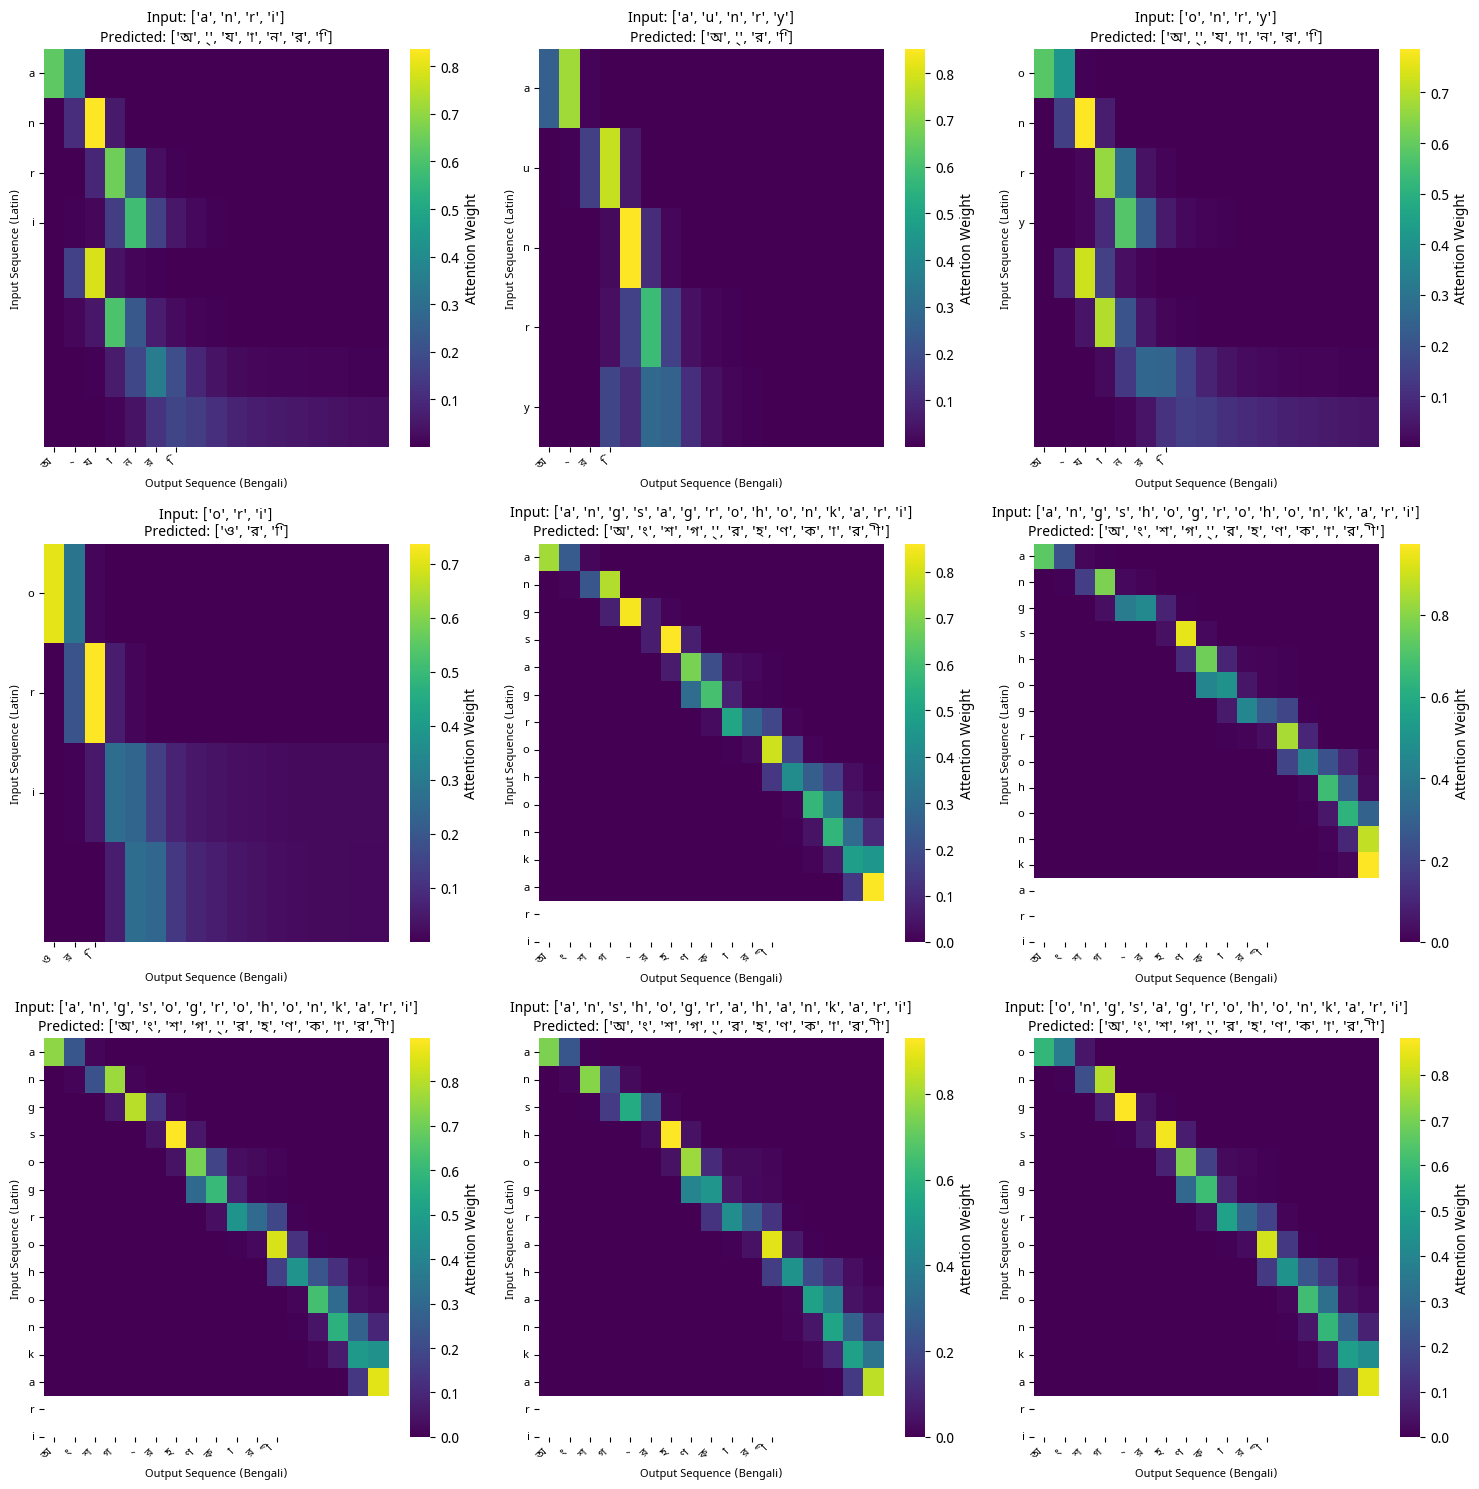

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# df = test_model(
#     test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
#     train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
#     model_path='/kaggle/working/best_model.pt',
#     src_vocab_path=None,  # Update if saved
#     tgt_vocab_path=None,  # Update if saved
#     output_csv='/kaggle/working/test_predictions.csv',
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     emb_dim=64,
#     hidden_dim=128,
#     enc_layers=1,
#     dec_layers=1,
#     cell_type='GRU',
#     dropout=0.2,
#     beam_size=3,
#     batch_size=64
# )
df = test_model(
    test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
    train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
    model_path='/kaggle/working/best_model.pt',
    output_csv='/kaggle/working/test_predictions.csv',
    heatmap_output='/kaggle/working/attention_heatmaps.png',
    src_vocab_path=None,  # Update if saved
    tgt_vocab_path=None,  # Update if saved
    device='cuda' if torch.cuda.is_available() else 'cpu',
    emb_dim=128,
    hidden_dim=256,
    enc_layers=3,
    dec_layers=3,
    cell_type='LSTM',
    dropout=0.4,
    beam_size=1,
    batch_size=64
)



In [26]:
import os
file_path = '/kaggle/working/test_predictions.csv'
if os.path.exists(file_path):
    print(f"File exists at {file_path}")
else:
    print("File not found! Check if test_model ran successfully.")

File exists at /kaggle/working/test_predictions.csv


In [27]:
df.to_csv('/kaggle/working/my_modified_file.csv', index=False)


In [28]:
import pandas as pd
df=pd.read_csv('/kaggle/working/test_predictions.csv')
sample_df = df.sample(50)
styled_df = sample_df.style.apply(highlight_correct, axis=1)
print("\nSample Test Set Predictions (First 50):")
display(styled_df)


Sample Test Set Predictions (First 50):


,Input (Latin),Ground Truth (Bengali),Predicted (Bengali)
5437,phuko,ফুকো,ফুকো
5972,beniphita,বেনিফিট,বেনিফিত
724,azzu,আজ্জু,আজ্জু
3373,diena,ডিএনএ,ডিএন
4988,patterner,প্যাটার্নের,প্যাটারনের
2594,cholochchitrogulo,চলচ্চিত্রগুলো,চলচ্চিত্রগুলো
3046,zayanta,জায়ান্ট,জ্যান্ট
3299,thakurmar,ঠাকুরমার,ঠাকুর্মার
8608,suborno,সূবর্ণ,সুবর্ণ
6848,mursi,মুরসি,মুর্সি


In [8]:
# def highlight_correct(row):
#     return ['background-color: lightgreen' if row['Predicted (Bengali)'] == row['Ground Truth (Bengali)'] else 'background-color: pink'] * 3

# def decode_indices(indices, index_to_token, ignore_tokens):
#     """Decode indices into tokens, ignoring specified tokens."""
#     valid_indices = [index.item() for index in indices if index.item() not in ignore_tokens]
#     return ''.join([index_to_token.get(index, '?') for index in valid_indices])
# def plot_attention(ax, input_text, output_text, attention_weights, font_properties):
#     """Plot attention weights using seaborn's heatmap with Bengali font support."""
#     import seaborn as sns
#     import numpy as np

#     # Ensure attention_weights is 2D [tgt_len, src_len]
#     if attention_weights.dim() == 1:
#         attention_weights = attention_weights.unsqueeze(1)
#     elif attention_weights.dim() > 2:
#         attention_weights = attention_weights.squeeze()
#         if attention_weights.dim() == 1:
#             attention_weights = attention_weights.unsqueeze(1)
#         elif attention_weights.dim() > 2:
#             raise ValueError(f"Attention weights have invalid shape: {attention_weights.shape}")
    
#     attention_weights = attention_weights.cpu().numpy()
    
#     # Create the heatmap with improved settings
#     sns.heatmap(
#         attention_weights,
#         xticklabels=output_text,
#         yticklabels=input_text,
#         ax=ax,
#         cmap='YlOrRd',
#         cbar=True,
#         cbar_kws={'label': 'Attention Weight', 'pad': 0.05},
#         square=True,
#         annot=True,
#         fmt='.2f',
#         annot_kws={'size': 8},
#         linewidths=0.5,
#         linecolor='white',
#     )
    
#     # Adjust label settings
#     ax.set_xticklabels(
#         output_text,
#         fontproperties=font_properties,
#         rotation=45,
#         ha='right',
#         fontsize=10,
#     )
#     ax.set_yticklabels(
#         input_text,
#         fontproperties=font_properties,
#         rotation=0,
#         fontsize=10,
#     )
    
#     # Improve axis labels and title
#     ax.set_xlabel('Output Sequence (Bengali)', fontsize=12, labelpad=10)
#     ax.set_ylabel('Input Sequence (Latin)', fontsize=12, labelpad=10)
#     ax.set_title(
#         f'Input: {input_text}\nPredicted: {output_text}',
#         fontproperties=font_properties,
#         fontsize=12,
#         pad=15,
#     )
    
#     ax.tick_params(axis='both', which='major', labelsize=10, length=0)

# def test_model(
#     test_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv',
#     train_path='/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv',
#     model_path='/kaggle/working/best_model.pt',
#     output_csv='/kaggle/working/test_predictions.csv',
#     heatmap_output='/kaggle/working/attention_heatmaps.png',
#     src_vocab_path=None,
#     tgt_vocab_path=None,
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     emb_dim=64,
#     hidden_dim=256,
#     enc_layers=3,
#     dec_layers=2,
#     cell_type='GRU',
#     dropout=0.2,
#     beam_size=3,
#     batch_size=64
# ):
#     """
#     Test the trained attention-based Seq2Seq model on the test dataset, display sample predictions,
#     generate predictions for the entire test set, and create a 3x3 grid of attention heatmaps.
#     """
#     import matplotlib.pyplot as plt
#     import matplotlib.font_manager as fm
#     from tqdm import tqdm
    
#     # Load and register the Bengali font globally
#     bengali_font_path = "/kaggle/input/notosansbengalifont/NotoSansBengali-Regular.ttf"
#     try:
#         fm.fontManager.addfont(bengali_font_path)
#         plt.rcParams['font.family'] = 'Noto Sans Bengali'
#         plt.rcParams['font.sans-serif'] = ['Noto Sans Bengali', 'sans-serif']
#         bengali_font = fm.FontProperties(fname=bengali_font_path, size=10)
#         print("Bengali font loaded successfully.")
#     except Exception as e:
#         print(f"Error loading Bengali font: {e}")
#         print("Falling back to default font, Bengali characters may not render correctly.")
#         bengali_font = fm.FontProperties(size=10)
    
#     # Initialize DataPreprocessor
#     preprocessor = DataPreprocessor(batch_size=batch_size, device=device)
    
#     # Load vocabularies
#     if src_vocab_path and tgt_vocab_path:
#         try:
#             with open(src_vocab_path, 'rb') as f:
#                 preprocessor.src_vocab = pickle.load(f)
#             with open(tgt_vocab_path, 'rb') as f:
#                 preprocessor.tgt_vocab = pickle.load(f)
#             print("Vocabularies loaded from provided paths.")
#         except Exception as e:
#             print(f"Error loading vocabularies: {e}")
#             print("Falling back to rebuilding vocabularies from training data.")
#             train_data = preprocessor.load_dataset(train_path)
#             preprocessor.build_vocabularies(train_data)
#     else:
#         train_data = preprocessor.load_dataset(train_path)
#         preprocessor.build_vocabularies(train_data)
#         print("Warning: Vocabularies rebuilt from training data. Ensure consistency with training.")
    
#     # Load test dataset
#     test_data = preprocessor.load_dataset(test_path)
    
#     # Prepare test data loader
#     _, _, test_loader = preprocessor.prepare_data(test_data, test_data, test_data)
    
#     # Initialize model
#     encoder = Encoder(
#         input_size=len(preprocessor.src_vocab),
#         embedding_dim=emb_dim,
#         hidden_size=hidden_dim,
#         num_layers=enc_layers,
#         cell_type=cell_type,
#         dropout=dropout
#     )
#     decoder = Decoder(
#         output_size=len(preprocessor.tgt_vocab),
#         embedding_dim=emb_dim,
#         hidden_size=hidden_dim,
#         num_layers=dec_layers,
#         cell_type=cell_type,
#         dropout=dropout
#     )
#     model = Seq2Seq(encoder, decoder).to(device)
    
#     # Load trained model weights
#     try:
#         model.load_state_dict(torch.load(model_path, map_location=device))
#         print("Model weights loaded successfully.")
#     except RuntimeError as e:
#         print(f"Error loading model weights: {e}")
#         print("Ensure hyperparameters match the trained model. Check WandB run config.")
#         return
    
#     model.eval()
    
#     # Initialize Trainer (for evaluation)
#     config = type('Config', (), {
#         'beam_size': beam_size,
#         'teacher_forcing': 0.7,
#         'epochs': 1,
#         'learning_rate': 0.0005
#     })()
#     trainer = Trainer(
#         model=model,
#         train_loader=test_loader,
#         val_loader=test_loader,
#         config=config,
#         device=device,
#         save_path=model_path
#     )
    
#     # Evaluate on test set
#     print("\nTest Set Evaluation:")
#     test_loss, test_token_acc, test_seq_acc = trainer.evaluate(test_loader)
#     print(f'Test Loss: {test_loss:.4f} | Test Token Acc: {test_token_acc*100:.2f}% | Test Seq Acc: {test_seq_acc*100:.2f}%')
    
#     # Generate predictions for the entire test set
#     all_data = []
#     heatmap_data = []
#     inv_src_vocab = {v: k for k, v in preprocessor.src_vocab.items()}
#     inv_tgt_vocab = {v: k for k, v in preprocessor.tgt_vocab.items()}
    
#     # Define ignore tokens
#     ignore_tokens = {
#         preprocessor.src_vocab.get('<EOS>'),
#         preprocessor.src_vocab.get('<PAD>'),
#         preprocessor.tgt_vocab.get('<EOS>'),
#         preprocessor.tgt_vocab.get('<PAD>'),
#         preprocessor.tgt_vocab.get('<SOS>')
#     }
    
#     print("\nGenerating predictions for the entire test set...")
#     for batch_idx, (src_sample, tgt_sample, src_strs, tgt_strs) in enumerate(tqdm(test_loader, desc="Predicting")):
#         src_sample = src_sample.to(device)
#         preds, attn_weights_list = model.predict_with_attention(src_sample, max_len=30, beam_size=beam_size)
        
#         for i in range(len(preds)):
#             input_str = decode_indices(src_sample[i], inv_src_vocab, ignore_tokens)
#             target_str = decode_indices(tgt_sample[i], inv_tgt_vocab, ignore_tokens)
#             pred_str = decode_indices(preds[i], inv_tgt_vocab, ignore_tokens)
#             all_data.append([input_str, target_str, pred_str])
            
#             # Collect data for heatmap (first 9 valid samples)
#             if len(heatmap_data) < 9:
#                 try:
#                     attn_weights = torch.cat([w.detach() for w in attn_weights_list[i]], dim=0)
#                 except Exception as e:
#                     print(f"Error concatenating attention weights for sample {len(heatmap_data)+1}: {e}")
#                     continue
                
#                 # Ensure attn_weights is [tgt_len, src_len]
#                 if attn_weights.dim() != 2:
#                     print(f"Invalid attention weights shape for sample {len(heatmap_data)+1}: {attn_weights.shape}")
#                     src_len = len([t for t in src_sample[i] if t.item() not in ignore_tokens])
#                     tgt_len = len([t for t in preds[i] if t.item() not in ignore_tokens])
#                     if src_len > 0 and tgt_len > 0:
#                         attn_weights = torch.ones((tgt_len, src_len), device=device) / src_len
#                         print(f"Using mock attention weights [{tgt_len}, {src_len}] for sample {len(heatmap_data)+1}")
#                     else:
#                         print(f"Skipping sample {len(heatmap_data)+1}: Invalid token lengths (src_len={src_len}, tgt_len={tgt_len})")
#                         continue
                
#                 heatmap_data.append({
#                     'src_tokens': list(input_str),
#                     'tgt_tokens': list(pred_str),
#                     'attn_weights': attn_weights,
#                     'input_str': input_str,
#                     'pred_str': pred_str
#                 })
    
#     # Save predictions to CSV
#     df = pd.DataFrame(all_data, columns=['Input (Latin)', 'Ground Truth (Bengali)', 'Predicted (Bengali)'])
#     try:
#         df.to_csv(output_csv, index=False)
#         print(f"Predictions saved to {output_csv}")
#     except Exception as e:
#         print(f"Error saving CSV file: {e}")
    
#     # # Display sample predictions (first 9)
#     # sample_df = df.head(35)  # Fixed from 29 to 9 to match the comment
#     # styled_df = sample_df.style.apply(highlight_correct, axis=1)
#     # print("\nSample Test Set Predictions (First 35):")
#     # display(styled_df)
    
#     # Generate attention heatmaps
#     if heatmap_data:
#         n_samples = min(9, len(heatmap_data))
#         rows = min(3, (n_samples + 2) // 3)
#         fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows))
#         if n_samples == 1:
#             axes = [axes]
#         else:
#             axes = axes.flatten()
        
#         for i in range(n_samples):
#             data = heatmap_data[i]
#             try:
#                 plot_attention(axes[i], data['src_tokens'], data['tgt_tokens'], data['attn_weights'], bengali_font)
#             except Exception as e:
#                 print(f"Error plotting heatmap for sample {i+1}: {e}")
        
#         # Hide unused subplots
#         for j in range(n_samples, len(axes)):
#             axes[j].set_visible(False)
        
#         plt.tight_layout()
#         try:
#             plt.savefig(heatmap_output, dpi=300, bbox_inches='tight')
#             print(f"Attention heatmaps saved to {heatmap_output}")
#         except Exception as e:
#             print(f"Error saving heatmap: {e}")
#         plt.show()
#     else:
#         print("No valid attention weights for heatmap generation.")
    
#     return df